# Optic Flow
Inspired by: A Robust Road Vanishing Point Detection Adapted to the
Real-World Driving Scenes

Based on the:
1. analysis
2. stable motion detection
3. stationary point-based motion vector selection
4. angle-based RANSAC
(RANdom SAmple Consensus) voting

In [1]:
import cv2
import numpy as np
import os
import copy
from matplotlib import pyplot as plt

# create temp folder
if not os.path.exists('temp'):
    os.makedirs('temp')

In [2]:
file = "test_20s_video.MP4"
cap = cv2.VideoCapture(file)
total_number_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total number of frames: ", total_number_of_frames)

Total number of frames:  624


In [3]:
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # mask bottom
    gray[-400:] = 0
    # mask sides
    gray[:, :100] = 0
    gray[:, -100:] = 0
    # blur
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    return gray

def get_frame(cap, frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    processed_frame = preprocess_frame(frame)
    return frame, processed_frame

# Video Builder

In [4]:
class VideoBuilder:
    def __init__(self, filename, fps):
        self.fps = fps
        self.output_file = filename
        self.recorder = None

    def add_frame(self, frame):
        if self.recorder is None:
            self.recorder = cv2.VideoWriter(self.output_file, cv2.VideoWriter_fourcc(*'XVID'), self.fps, (frame.shape[1], frame.shape[0]))

        self.recorder.write(frame)

    def stop_recording(self):
        if self.recorder is not None:
            self.recorder.release()
            self.recorder = None


# Motion Vector Detection

In [5]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 500,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# minimum displacement
Min_displacement = 1
max_trajectory_length = 50

### Corner Feature Detection
Detect corners using Shi-Tomasi corner detection algorithm.

In [6]:
all_corners = []

corner_cache = {}

def get_points_of_frame(frame_number):
    if frame_number in corner_cache:
        return corner_cache.get(frame_number)
    
    original_frame, frame = get_frame(cap, frame_number)

    # shi-tomasi corner detection
    corners = cv2.goodFeaturesToTrack(frame, mask = None, **feature_params)

    if corners is not None:
        for corner in corners:
            x, y = corner.ravel()
            cv2.circle(original_frame, (int(x), int(y)), 3, 255, -1)

    corner_cache[frame_number] = corners
    return corners

### Feature Tracking using Lucas-Kanade Optical Flow

#### Output video of the motion vectors

In [7]:
# random colours to label different lines
color = np.random.randint(0, 255, (400000, 3))

def get_frame_with_trajectories(frame_number, trajectories):
    original_frame, _ = get_frame(cap, frame_number)
    mask = np.zeros_like(original_frame)
    
    # Draw the full trajectories
    for start_position, points in trajectories.items():
        color_idx = hash(start_position) % len(color)  # Get a consistent color for each start position
        for j in range(1, len(points)):
            a, b = points[j].ravel()
            c, d = points[j - 1].ravel()
            mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[color_idx].tolist(), 2)

    # Draw current points as circles
    for start_position, points in trajectories.items():
        color_idx = hash(start_position) % len(color)  # Re-use the consistent color
        a, b = points[-1].ravel()  # Last known position
        original_frame = cv2.circle(original_frame, (int(a), int(b)), 5, color[color_idx].tolist(), -1)

    
    # draw on image
    original_frame = cv2.add(original_frame, mask)

    return original_frame

def output_video_of_trajectories(frame_trajectories, filename):
    video = VideoBuilder(filename, 30)
    for i in range(total_number_of_frames):
        frame_number = i
        trajectories = frame_trajectories[i]
        frame = get_frame_with_trajectories(frame_number, trajectories)
        video.add_frame(frame)
    video.stop_recording()

#### Remove stationary points

In [8]:
def filter_for_minimum_displacement(good_old, good_new):
    new_good_old = []
    new_good_new = []
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        new_x, new_y = new.ravel()
        old_x, old_y = old.ravel()
        if abs(new_x - old_x) > Min_displacement or abs(new_y - old_y) > Min_displacement:
            new_good_old.append(old)
            new_good_new.append(new)
    return np.array(new_good_old), np.array(new_good_new)

#### Clip max trajectory length

In [9]:
def clip_max_trajectory(traj):
    return traj[-max_trajectory_length:]

#### Perform tracking
- Points over many consecutive frames are considered stable motion vectors

In [10]:
# initial frame
p0 = get_points_of_frame(0)
_, last_frame = get_frame(cap, 0)

# Dictionary to store trajectories of each point
trajectories = {tuple(p.ravel()): [p] for p in p0}
all_frame_trajectories = []
all_frame_trajectories.append(copy.deepcopy(trajectories))

for i in range(1, total_number_of_frames):
    frame, frame_gray = get_frame(cap, i)
    
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(last_frame, frame_gray, p0, None, **lk_params)

    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]

    # Filter out points that have not moved enough
    good_old, good_new = filter_for_minimum_displacement(good_old, good_new)

    new_trajectories = {}
    for new, old in zip(good_new, good_old):
        start_position = tuple(old.ravel())  # Use the original position as the key
        next_iterations_start_position = tuple(new.ravel())  # Use the new position as the key for the next iteration
        if start_position in trajectories:
            # Append new position to the trajectory with the same start position
            trajectories[start_position].append(new)
            # Keep this trajectory in the new set of trajectories
            new_trajectories[next_iterations_start_position] = clip_max_trajectory(trajectories[start_position])

    # Replace old trajectories with updated ones that exclude lost points
    trajectories = new_trajectories

    last_frame = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

    if len(p0) < 400:
        new_points = get_points_of_frame(i)
        p0 = np.concatenate((p0, new_points), axis=0)
        for new_p in new_points:
            start_position = tuple(new_p.ravel())
            if start_position not in trajectories:
                trajectories[start_position] = [new_p]

    all_frame_trajectories.append(copy.deepcopy(trajectories))

#### Output video of all unprocessed trajectories

In [11]:
output_video_of_trajectories(all_frame_trajectories, 'temp/all_trajectories.avi')

# Choosing stationary object motion vectors

# R-VP Voting
Using RANSAC to find the best vanishing point

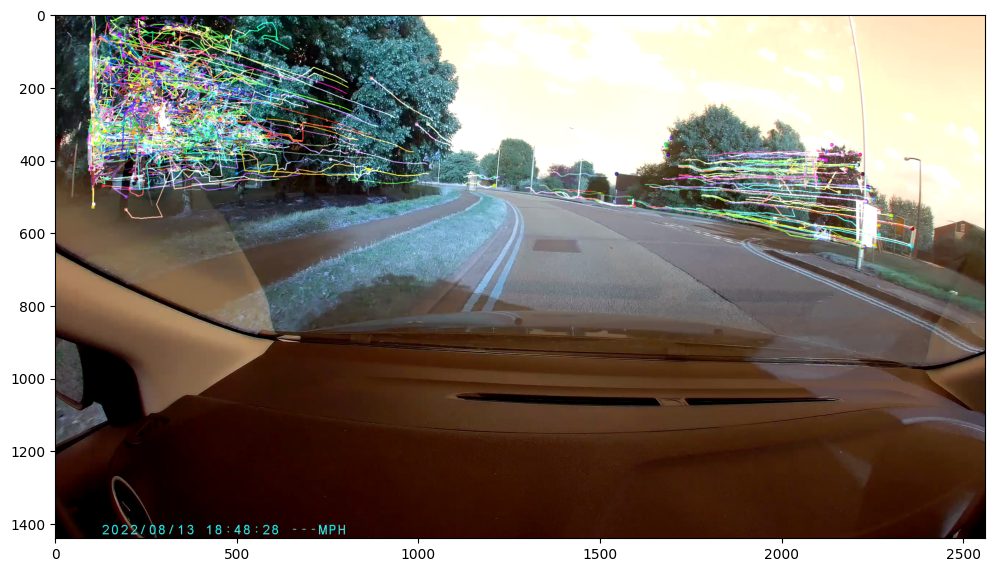

In [12]:
example_frame = 420
# Display the trajectories of the points
trajectories = all_frame_trajectories[example_frame]

ignore_short_history_trajectories = {start_position: points for start_position, points in trajectories.items() if len(points) > 20}

frame = get_frame_with_trajectories(example_frame, ignore_short_history_trajectories)
plt.figure(figsize=(12, 12))
plt.imshow(frame)

In [13]:
import numpy as np

def find_vanishing_point(line_segments, iterations=500, threshold=10):
    best_vanishing_point = None
    max_inliers = 0
    
    for _ in range(iterations):
        # Randomly select two line segments
        idx1, idx2 = np.random.choice(len(line_segments), 2, replace=False)
        (x1, y1), (x2, y2) = line_segments[idx1]
        (x3, y3), (x4, y4) = line_segments[idx2]
        
        # Calculate slopes and intercepts if possible
        try:
            m1 = (y2 - y1) / (x2 - x1)
            m2 = (y4 - y3) / (x4 - x3)
            
            # Skip parallel lines (no unique intersection)
            if m1 == m2:
                continue
            
            # Calculate intersection point
            x_intersect = (m1 * x1 - y1 - m2 * x3 + y3) / (m1 - m2)
            y_intersect = m1 * (x_intersect - x1) + y1
            intersection_point = np.array([x_intersect, y_intersect])
            
            # Count inliers based on threshold distance
            inliers = []
            for (p1, p2) in line_segments:
                x1, y1 = p1
                x2, y2 = p2
                # Calculate the perpendicular distance from the line to the intersection point
                if x2 != x1:
                    m = (y2 - y1) / (x2 - x1)
                    c = y1 - m * x1
                    y_hat = m * intersection_point[0] + c
                    distance = abs(y_hat - intersection_point[1])
                else:
                    # Vertical line case
                    distance = abs(intersection_point[0] - x1)

                if distance < threshold:
                    inliers.append((p1, p2))
            
            # Update best vanishing point if more inliers found
            if len(inliers) > max_inliers:
                best_vanishing_point = intersection_point
                max_inliers = len(inliers)
                
        except ZeroDivisionError:
            # Skip if division by zero (vertical or horizontal lines)
            continue
    
    return best_vanishing_point, max_inliers

In [14]:
ransac_vectors = []

for start_position, points in ignore_short_history_trajectories.items():
    for i in range(1, len(points)):
        # Store both start and end points of each vector
        start_point = points[i - 1].ravel()
        end_point = points[i].ravel()
        ransac_vectors.append([start_point, end_point])

ransac_vectors = np.array(ransac_vectors)

vanishing_point, inliers_count = find_vanishing_point(ransac_vectors)
print("Vanishing Point:", vanishing_point)
print("Number of Inliers:", inliers_count)

Vanishing Point: [1247.5028  429.3503]
Number of Inliers: 811


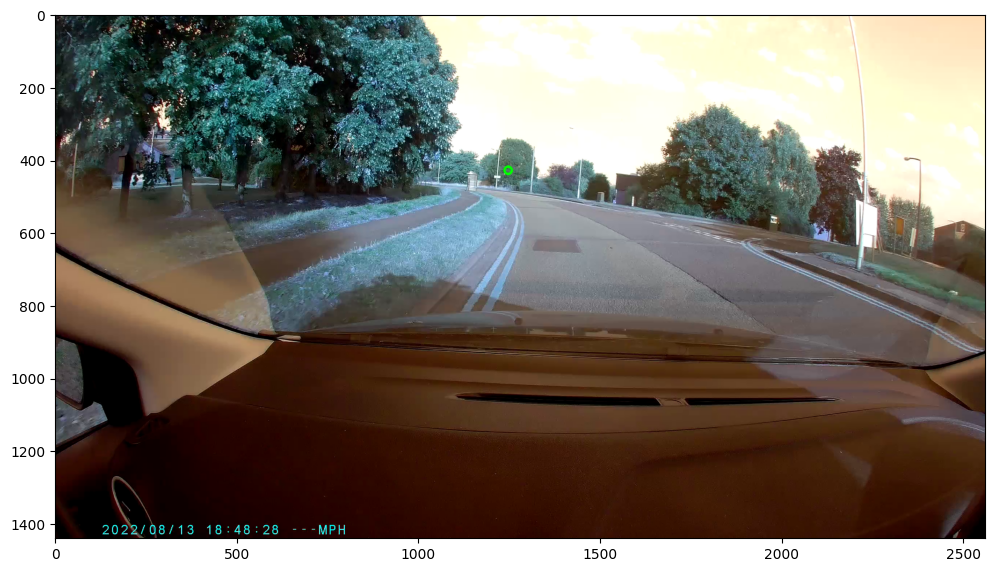

In [15]:
frame = get_frame(cap, example_frame)[0]

# Draw vp
if vanishing_point is not None:
    frame = cv2.circle(frame, tuple(vanishing_point.astype(int)), 10, (0, 255, 0), 5)

plt.figure(figsize=(12, 12))
plt.imshow(frame)

In [ ]:
all_vp = []

for i in range(total_number_of_frames):
    trajectories = all_frame_trajectories[i]
    ignore_short_history_trajectories = {start_position: points for start_position, points in trajectories.items() if len(points) > 20}
    ransac_vectors = []

    for start_position, points in ignore_short_history_trajectories.items():
        for i in range(1, len(points)):
            start_point = points[i - 1].ravel()
            end_point = points[i].ravel()
            ransac_vectors.append([start_point, end_point])

    ransac_vectors = np.array(ransac_vectors)

    if len(ransac_vectors) < 2:
        all_vp.append(np.array([0, 0]))
        continue
    vanishing_point, inliers_count = find_vanishing_point(ransac_vectors)
    all_vp.append(vanishing_point)

all_vp = np.array(all_vp)

In [ ]:
def output_video_of_R_VP(VP, filename):
    video = VideoBuilder(filename, 30)
    for i in range(0, len(VP)):
        frame_number = i
        vanishing_point = VP[i]
        frame = get_frame(cap, frame_number)[0]
        if vanishing_point is not None:
            frame = cv2.circle(frame, tuple(vanishing_point.astype(int)), 10, (0, 255, 0), 5)
        video.add_frame(frame)
    video.stop_recording()

output_video_of_R_VP(processed_vp, 'temp/all_vp.avi')